### Import des bibliothéques
---

In [1]:
import io
import os
import re
import shutil
import tarfile
import string
import torch
import tiktoken
import requests
import numpy as np
import pandas as pd
import plotly.express as px
from plotly import graph_objects as go
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchinfo import summary
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report

device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


### Chargement des données
---

In [2]:
file_path = "data/spam_clean.csv"
df = pd.read_csv(file_path)
df.head()

,Label,Message,nbre_caractère
0,0,"Go until jurong point, crazy.. Available only ...",111
1,0,Ok lar... Joking wif u oni...,29
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,0,U dun say so early hor... U c already then say...,49
4,0,"Nah I don't think he goes to usf, he lives aro...",61


### Tokenisation et Préparation des données pour PyTorch
---

In [3]:
# chargement du tokenisateur pour découpage en token 
# ( 1 token classique = 1 mot (pb si mot rare) - 1 token moderne tiktoken/bert = 1 sous-mot, morceaux de mots)
tokenizer = tiktoken.get_encoding("cl100k_base")

# fonction encodage
def encode_texts(texts):
    return [tokenizer.encode(text) for text in texts] # prend une liste de textes et retourne une liste de listes de tokens.

# Séparation train/test
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['Message'],
    df['Label'],
    test_size=0.2,
    random_state=42,
    stratify=df['Label'] # désequilibre montrer en eda
)

# Encoder les textes en tokens : listes de nombres qui représentent les messages
train_tokens = encode_texts(train_texts.tolist())
test_tokens = encode_texts(test_texts.tolist())

print(f"Exemple texte d'entraînement  encodé : {train_tokens[0]} \n")

# Aanlyse des longueurs
# Calcul longueur des messages (toutes les entrées en Pytorch doivent avoir la même dimension = padding)
train_len = [len(seq) for seq in train_tokens]
test_len = [len(seq) for seq in test_tokens]
print(f"Pour le train, la longueur maximale est de : {max(train_len)} et la moyenne de {np.mean(train_len).round(2)}")
print(f"Pour le test, la longueur maximale est de : {max(test_len)} et la moyenne de {np.mean(test_len).round(2)}")

# Choix du max_len avec le calcul du percentile 
max_len_95 = int(np.percentile(train_len, 95))
print(f"95 % des messages ont une longueur ≤ {max_len_95}, ce qui conforme la visualisation \n")

# Visualisation Distribution longueur de chaque message pour le train + ligne de padding
fig = px.histogram(
    train_len, 
    nbins=30)
fig.add_vline(
    x=max_len_95, 
    line_dash="dash", 
    line_color="red",
    annotation_text=f"Padding = {max_len_95}", 
    annotation_position="top right")
fig.update_layout(
    title="Distribution de la longueur des messages",
    xaxis_title="Nombre de tokens par message",
    yaxis_title="Nombre de messages"
)
fig.show()
print("Sur le graph, on constate que la majorité des messages ont moins de 50 tokens, avec un pic autour de 10/20 tokens")

# Padding (séquences avec la même longueur à 50)
def pad_sequences(sequences, max_length):
    # Pad ou tronque les séquences pour qu'elles aient la même longueur
    return [seq[:max_length] + [0]*(max_length - len(seq)) if len(seq) < max_length else seq[:max_length] for seq in sequences]

train_tokens_padded = pad_sequences(train_tokens, max_len_95)
test_tokens_padded  = pad_sequences(test_tokens, max_len_95)

print(f"Longueur des séquences d'entraînement après padding : {len(train_tokens_padded[0])}")
print(f"Longueur des séquences de test après padding : {len(test_tokens_padded[0])}\n")

# Dataset Pytorch
class ATTDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = torch.tensor(texts, dtype=torch.long)
        self.labels = torch.tensor(labels, dtype=torch.float32)  # float32 pour BCEWithLogitsLoss
    def __len__(self):
        return len(self.texts)
    def __getitem__(self, idx):
        return self.texts[idx], self.labels[idx]

# Dataset Train et test 
train_dataset = ATTDataset(train_tokens_padded, train_labels.tolist())
test_dataset = ATTDataset(test_tokens_padded, test_labels.tolist())

# Dataset Train/Validation slipt à l'intérieur du train
train_size = int(0.8 * len(train_dataset))
val_size   = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

text, label = next(iter(train_loader))
print(label)
print(text)


Exemple texte d'entraînement  encodé : [47439, 389, 4400, 2294, 960, 9188] 

Pour le train, la longueur maximale est de : 259 et la moyenne de 22.44
Pour le test, la longueur maximale est de : 169 et la moyenne de 22.71
95 % des messages ont une longueur ≤ 52, ce qui conforme la visualisation 



Sur le graph, on constate que la majorité des messages ont moins de 50 tokens, avec un pic autour de 10/20 tokens
Longueur des séquences d'entraînement après padding : 52
Longueur des séquences de test après padding : 52

tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.])
tensor([[24220,    11,   304,  ...,     0,     0,     0],
        [47618, 30198,  2403,  ...,     0,     0,     0],
        [11839,   902,   701,  ...,     0,     0,     0],
        ...,
        [   53,  1940,   396,  ...,     0,     0,     0],
        [   56,   455,   912,  ...,     0,     0,     0],
        [ 5519,   499,  1390,  ...,     0,     0,     0]])


### Modéle réseau de neurones
---
Le modèle choisi pour la détection de spam est un TextClassifier, qui contient une couche d’Embedding suivie d’un pooling et d’une couche linéaire pour produire la prédiction spam/ham.”

In [4]:
# TextClassifier
vocab_size = tokenizer.n_vocab

class TextClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim=16): # initialise le modéle
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0) # couche embedding : transforme les tokens en vecteur
        self.pooling = nn.AdaptiveAvgPool1d(1) # reduit la dimension (vecteur moy, le modéle n'a plus qu'un seul vecteur à analyser)
        self.fc = nn.Linear(embed_dim, 1)  # output logit pour BCEWithLogitsLoss

    def forward(self, text):
        # text : (batch_size, seq_len)
        embedded = self.embedding(text)          # (batch_size, seq_len, embed_dim)
        pooled = embedded.mean(dim=1)            # (batch_size, embed_dim) : moyenne sur seq_len
        return self.fc(pooled)                    # (batch_size, 1) : logit brut

model = TextClassifier(vocab_size=vocab_size, embed_dim=16)

print(model)
summary(model, input_data=text)


TextClassifier(
  (embedding): Embedding(100277, 16, padding_idx=0)
  (pooling): AdaptiveAvgPool1d(output_size=1)
  (fc): Linear(in_features=16, out_features=1, bias=True)
)


Layer (type:depth-idx)                   Output Shape              Param #
TextClassifier                           [32, 1]                   --
├─Embedding: 1-1                         [32, 52, 16]              1,604,432
├─Linear: 1-2                            [32, 1]                   17
Total params: 1,604,449
Trainable params: 1,604,449
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 51.34
Input size (MB): 0.01
Forward/backward pass size (MB): 0.21
Params size (MB): 6.42
Estimated Total Size (MB): 6.64

### Entrainement du Modéle
---

In [5]:
# Définition de la loss et de l'optimiseur
criterion = nn.BCEWithLogitsLoss()  # prend les logits bruts du modèle (sortie non transformée du modéle) fonction de paerte
optimizer = optim.Adam(model.parameters(), lr=0.001) # lr learning rate : taille du pas, Adam optimiseur

# Fonction d'entraînement
def train(model, train_loader, val_loader, criterion, optimizer, epochs=20):
    history = {"loss": [], "val_loss": [], "accuracy": [], "val_accuracy": []}

    for epoch in range(epochs):
        model.train()  # mode entraînement
        total_loss, correct = 0, 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device).float()

            optimizer.zero_grad()            # reset des gradients
            logits = model(inputs).squeeze() # sortie du modèle
            loss = criterion(logits, labels) # calcul de la loss
            loss.backward()                  # backpropagation
            optimizer.step()                 # mise à jour des poids

            total_loss += loss.item()
            preds = (torch.sigmoid(logits) > 0.5).float()  # convertit logits → 0 ou 1
            correct += (preds == labels).sum().item()

        train_loss = total_loss / len(train_loader)
        train_acc = correct / len(train_loader.dataset)

        # Validation :mode évaluation (model.eval()), gradients désactivés (torch.no_grad()). 
        # Pour chaque batch : calcul des logits, perte avec criterion, sigmoid pour obtenir les prédictions binaires, 
        # comparaison avec les labels pour compter les bonnes réponses. Calcul final : perte moyenne et précision.
        model.eval()
        val_loss, val_correct = 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device).float()
                logits = model(inputs).squeeze()
                loss = criterion(logits, labels)
                val_loss += loss.item()

                preds = (torch.sigmoid(logits) > 0.5).float()
                val_correct += (preds == labels).sum().item()

        val_loss /= len(val_loader)
        val_acc = val_correct / len(val_loader.dataset)

        # Sauvegarde et affichage des métriques
        history["loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["accuracy"].append(train_acc)
        history["val_accuracy"].append(val_acc)

        print(f"Epoch {epoch+1}/{epochs} | "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    return history

# Appel de la fonction d'entraînement
history = train(model, train_loader, val_loader, criterion, optimizer, epochs=20)


Epoch 1/20 | Train Loss: 0.6139, Train Acc: 0.8729 | Val Loss: 0.5877, Val Acc: 0.8677
Epoch 2/20 | Train Loss: 0.5548, Train Acc: 0.8808 | Val Loss: 0.5246, Val Acc: 0.8767
Epoch 3/20 | Train Loss: 0.4824, Train Acc: 0.8990 | Val Loss: 0.4509, Val Acc: 0.8969
Epoch 4/20 | Train Loss: 0.4039, Train Acc: 0.9206 | Val Loss: 0.3783, Val Acc: 0.9193
Epoch 5/20 | Train Loss: 0.3324, Train Acc: 0.9394 | Val Loss: 0.3165, Val Acc: 0.9383
Epoch 6/20 | Train Loss: 0.2731, Train Acc: 0.9532 | Val Loss: 0.2677, Val Acc: 0.9529
Epoch 7/20 | Train Loss: 0.2272, Train Acc: 0.9635 | Val Loss: 0.2298, Val Acc: 0.9585
Epoch 8/20 | Train Loss: 0.1914, Train Acc: 0.9705 | Val Loss: 0.2010, Val Acc: 0.9641
Epoch 9/20 | Train Loss: 0.1641, Train Acc: 0.9764 | Val Loss: 0.1784, Val Acc: 0.9664
Epoch 10/20 | Train Loss: 0.1424, Train Acc: 0.9795 | Val Loss: 0.1609, Val Acc: 0.9709
Epoch 11/20 | Train Loss: 0.1252, Train Acc: 0.9820 | Val Loss: 0.1467, Val Acc: 0.9709
Epoch 12/20 | Train Loss: 0.1111, Train A

### Evaluation et analyse
---

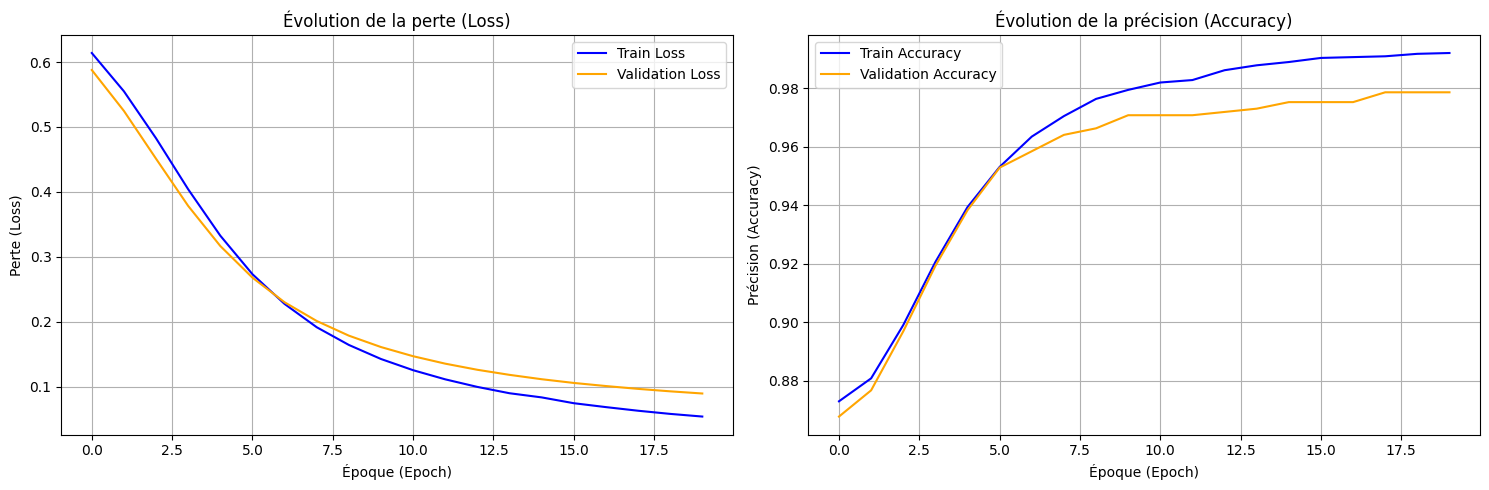


 Le modéle est  fiable avec une accuracy de 0.99 pour le train et pour la val.
 Les erreurs sont faibles également. Pas d'overfitting.


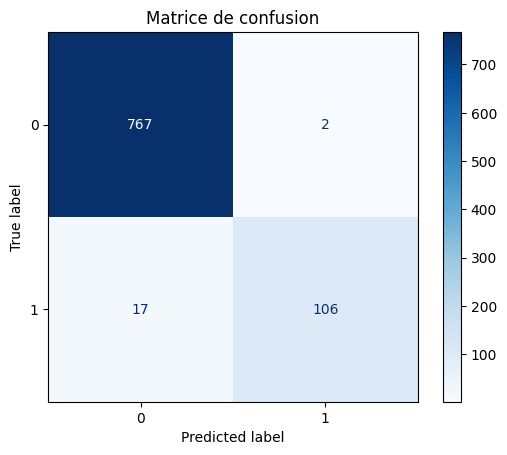

Nous avons un échantillon de 892 messages, le modéle est précis, il ne fait aucune fausse alerte
  Néanmoins, il rate quelques positifs, avec 11 faux-négatif

Rapport de classification :
              precision    recall  f1-score   support

         0.0      0.978     0.997     0.988       769
         1.0      0.981     0.862     0.918       123

    accuracy                          0.979       892
   macro avg      0.980     0.930     0.953       892
weighted avg      0.979     0.979     0.978       892

Accuracy : Globalement, le modèle se trompe très rarement : 99% de bonnes prédictions.
Précision : Quand il dit spam, c’est toujours du spam (0 faux positifs).
Recall : Il attrape 93% des spams, mais en laisse encore passer quelques-uns.
F1 : Le modèle est équilibré : à la fois fiable et efficace sur les spams.


In [6]:
# Visualisation Loss et Accuracy
plt.figure(figsize=(15, 5))

# Graphique 1 : Évolution de la perte (loss)
plt.subplot(1, 2, 1)
plt.plot(history["loss"], label="Train Loss", color="blue")
plt.plot(history["val_loss"], label="Validation Loss", color="orange")
plt.title("Évolution de la perte (Loss)")
plt.xlabel("Époque (Epoch)")
plt.ylabel("Perte (Loss)")
plt.legend()
plt.grid(True)

# Graphique 2 : Évolution de la précision (accuracy)
plt.subplot(1, 2, 2)
plt.plot(history["accuracy"], label="Train Accuracy", color="blue")
plt.plot(history["val_accuracy"], label="Validation Accuracy", color="orange")
plt.title("Évolution de la précision (Accuracy)")
plt.xlabel("Époque (Epoch)")
plt.ylabel("Précision (Accuracy)")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

print(f"\n Le modéle est  fiable avec une accuracy de 0.99 pour le train et pour la val.\n Les erreurs sont faibles également. Pas d'overfitting.")

# Matrice de Confusion sur le Val
y_true, y_pred = [], []
model.eval()
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        logits = model(inputs).squeeze()
        preds = (torch.sigmoid(logits) > 0.5).int().cpu().numpy()
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds)

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Matrice de confusion")
plt.show()

print(f"Nous avons un échantillon de 892 messages, le modéle est précis, il ne fait aucune fausse alerte\n  Néanmoins, il rate quelques positifs, avec 11 faux-négatif")

# Rapport complet (précision, rappel, F1 par classe)
print("\nRapport de classification :")
print(classification_report(y_true, y_pred, digits=3))
print("Accuracy : Globalement, le modèle se trompe très rarement : 99% de bonnes prédictions.\nPrécision : Quand il dit spam, c’est toujours du spam (0 faux positifs).\nRecall : Il attrape 93% des spams, mais en laisse encore passer quelques-uns.\nF1 : Le modèle est équilibré : à la fois fiable et efficace sur les spams.")



### Sauvegarde du Modéle
---

In [7]:
torch.save(model, "textclassifier_bcewithlogitsloss_full.pth")
